# Optuna Tuning | K-Nearest Neighbors
**K-Nearest Neighbors** (Classifier) hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

### 0.2 Constants

In [3]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'knn'

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [4]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [5]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [6]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [7]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [8]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [9]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 50),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])
    }

    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = KNeighborsClassifier(**params)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()


In [10]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-01-12 12:33:35,649] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [11]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

Cross validation scores: [0.47616057 0.4773106  0.47613315 0.47722475 0.47831156]
Average score: 0.4770281255646814


[I 2025-01-12 12:33:52,891] Trial 5 finished with value: 0.4770281255646814 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 5 with value: 0.4770281255646814.
[I 2025-01-12 12:33:55,457] Trial 3 finished with value: 0.4771053643150146 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 3 with value: 0.4771053643150146.


Cross validation scores: [0.47616057 0.47629761 0.4762428  0.47948661 0.47733922]
Average score: 0.4771053643150146


[I 2025-01-12 12:33:55,815] Trial 2 finished with value: 0.48712302915557926 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 2 with value: 0.48712302915557926.


Cross validation scores: [0.48986139 0.48357478 0.48554775 0.48770115 0.48893008]
Average score: 0.48712302915557926
Cross validation scores: [0.47629761 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.4763250138147043


[I 2025-01-12 12:33:56,660] Trial 0 finished with value: 0.4763250138147043 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 2 with value: 0.48712302915557926.
[I 2025-01-12 12:34:01,080] Trial 1 finished with value: 0.47633597337075617 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 2 with value: 0.48712302915557926.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 12:34:02,373] Trial 4 finished with value: 0.47633597337075617 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 2 with value: 0.48712302915557926.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 12:34:12,942] Trial 6 finished with value: 0.4860440027432169 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 2 with value: 0.48712302915557926.


Cross validation scores: [0.4892764  0.48365143 0.48487528 0.48518812 0.48722878]
Average score: 0.4860440027432169


[I 2025-01-12 12:34:14,851] Trial 7 finished with value: 0.4860440027432169 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: 0.48712302915557926.


Cross validation scores: [0.4892764  0.48365143 0.48487528 0.48518812 0.48722878]
Average score: 0.4860440027432169


[I 2025-01-12 12:34:15,867] Trial 8 finished with value: 0.4860440027432169 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 2 with value: 0.48712302915557926.


Cross validation scores: [0.4892764  0.48365143 0.48487528 0.48518812 0.48722878]
Average score: 0.4860440027432169
Cross validation scores: [0.4892764  0.48365143 0.48487528 0.48518812 0.48722878]
Average score: 0.4860440027432169


[I 2025-01-12 12:34:16,043] Trial 9 finished with value: 0.4860440027432169 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: 0.48712302915557926.
[I 2025-01-12 12:34:18,407] Trial 10 finished with value: 0.48670873695745254 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 2 with value: 0.48712302915557926.


Cross validation scores: [0.49008177 0.48365143 0.48479666 0.48510841 0.48990541]
Average score: 0.48670873695745254


[I 2025-01-12 12:34:22,072] Trial 11 finished with value: 0.4860440027432169 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 2 with value: 0.48712302915557926.


Cross validation scores: [0.4892764  0.48365143 0.48487528 0.48518812 0.48722878]
Average score: 0.4860440027432169


[I 2025-01-12 12:34:22,947] Trial 15 finished with value: 0.5179256932036052 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 15 with value: 0.5179256932036052.


Cross validation scores: [0.52060966 0.51259056 0.52133861 0.52036495 0.51472469]
Average score: 0.5179256932036052
Cross validation scores: [0.50077682 0.49520947 0.49812096 0.50051946 0.49883863]
Average score: 0.49869306601395735


[I 2025-01-12 12:34:26,306] Trial 13 finished with value: 0.49869306601395735 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 15 with value: 0.5179256932036052.
[I 2025-01-12 12:34:29,607] Trial 14 finished with value: 0.4882731027959898 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 15 with value: 0.5179256932036052.


Cross validation scores: [0.4913548  0.48345992 0.48554775 0.48946638 0.49153666]
Average score: 0.4882731027959898


[I 2025-01-12 12:34:30,868] Trial 18 finished with value: 0.5081790730450011 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 15 with value: 0.5179256932036052.


Cross validation scores: [0.51180003 0.50406928 0.5128015  0.51015889 0.50206566]
Average score: 0.5081790730450011


[I 2025-01-12 12:34:33,787] Trial 19 finished with value: 0.5186117806364187 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.52344606 0.51343104 0.52404482 0.5163331  0.51580388]
Average score: 0.5186117806364187


[I 2025-01-12 12:34:34,901] Trial 12 finished with value: 0.47633597337075617 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-12 12:34:35,934] Trial 16 finished with value: 0.48688004746216285 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.49012593 0.48365143 0.48475738 0.48600411 0.48986139]
Average score: 0.48688004746216285


[I 2025-01-12 12:34:37,204] Trial 21 finished with value: 0.5179256932036052 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.52060966 0.51259056 0.52133861 0.52036495 0.51472469]
Average score: 0.5179256932036052
Cross validation scores: [0.48986139 0.48357478 0.48550771 0.4868965  0.49065667]
Average score: 0.48729940790609777


[I 2025-01-12 12:34:37,408] Trial 17 finished with value: 0.48729940790609777 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 19 with value: 0.5186117806364187.
[I 2025-01-12 12:34:42,241] Trial 22 finished with value: 0.5071856304162022 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.51152761 0.5027907  0.51255794 0.50839802 0.50065388]
Average score: 0.5071856304162022


[I 2025-01-12 12:34:43,751] Trial 25 finished with value: 0.5179256932036052 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.52060966 0.51259056 0.52133861 0.52036495 0.51472469]
Average score: 0.5179256932036052


[I 2025-01-12 12:34:46,840] Trial 23 finished with value: 0.4883379975283188 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.49099246 0.48326883 0.48722878 0.48911704 0.49108287]
Average score: 0.4883379975283188


[I 2025-01-12 12:34:47,407] Trial 26 finished with value: 0.4967445952742109 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.50218448 0.48966119 0.49889071 0.49714087 0.49584573]
Average score: 0.4967445952742109


[I 2025-01-12 12:34:48,900] Trial 20 finished with value: 0.4860277075721483 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.4892764  0.48365143 0.48487528 0.48514826 0.48718717]
Average score: 0.4860277075721483


[I 2025-01-12 12:34:49,237] Trial 27 finished with value: 0.5186117806364187 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.52344606 0.51343104 0.52404482 0.5163331  0.51580388]
Average score: 0.5186117806364187


[I 2025-01-12 12:34:50,176] Trial 24 finished with value: 0.4864985726340734 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.48914634 0.4836131  0.48479666 0.48596348 0.48897328]
Average score: 0.4864985726340734


[I 2025-01-12 12:34:55,590] Trial 29 finished with value: 0.5179256932036052 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.52060966 0.51259056 0.52133861 0.52036495 0.51472469]
Average score: 0.5179256932036052


[I 2025-01-12 12:34:56,607] Trial 28 finished with value: 0.4890792525622791 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.4932544  0.48664821 0.48791243 0.48785811 0.48972312]
Average score: 0.4890792525622791
Cross validation scores: [0.48955446 0.48630047 0.48602526 0.49470527 0.48856634]
Average score: 0.4890303609066313


[I 2025-01-12 12:35:01,097] Trial 31 finished with value: 0.4890303609066313 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.
[I 2025-01-12 12:35:04,698] Trial 30 finished with value: 0.4860440027432169 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.4892764  0.48365143 0.48487528 0.48518812 0.48722878]
Average score: 0.4860440027432169


[I 2025-01-12 12:35:07,957] Trial 33 finished with value: 0.4763085730470154 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.47629761 0.47635241 0.47629761 0.47627021 0.47632501]
Average score: 0.4763085730470154


[I 2025-01-12 12:35:08,287] Trial 34 finished with value: 0.4890792525622791 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.4932544  0.48664821 0.48791243 0.48785811 0.48972312]
Average score: 0.4890792525622791
Cross validation scores: [0.4892764  0.48365143 0.48487528 0.48518812 0.48722878]
Average score: 0.4860440027432169
Cross validation scores: [0.52060966 0.51259056 0.52133861 0.52036495 0.51472469]
Average score: 0.5179256932036052


[I 2025-01-12 12:35:08,676] Trial 32 finished with value: 0.4860440027432169 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.
[I 2025-01-12 12:35:08,720] Trial 36 finished with value: 0.5179256932036052 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.4762428  0.4762428  0.4762154  0.47739646 0.47739646]
Average score: 0.47669878311260183


[I 2025-01-12 12:35:13,628] Trial 35 finished with value: 0.47669878311260183 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.
[I 2025-01-12 12:35:15,855] Trial 38 finished with value: 0.5071856304162022 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.51152761 0.5027907  0.51255794 0.50839802 0.50065388]
Average score: 0.5071856304162022
Cross validation scores: [0.49384649 0.48743348 0.4926311  0.49217658 0.495361  ]
Average score: 0.49228973054088476


[I 2025-01-12 12:35:15,946] Trial 37 finished with value: 0.49228973054088476 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.
[I 2025-01-12 12:35:16,381] Trial 40 finished with value: 0.5081790730450011 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.51180003 0.50406928 0.5128015  0.51015889 0.50206566]
Average score: 0.5081790730450011


[I 2025-01-12 12:35:19,353] Trial 41 finished with value: 0.4960761088703173 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.49857878 0.48867036 0.49973886 0.49424082 0.49915172]
Average score: 0.4960761088703173


[I 2025-01-12 12:35:19,935] Trial 39 finished with value: 0.4883379975283188 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.49099246 0.48326883 0.48722878 0.48911704 0.49108287]
Average score: 0.4883379975283188
Cross validation scores: [0.52060966 0.51259056 0.52133861 0.52036495 0.51472469]
Average score: 0.5179256932036052


[I 2025-01-12 12:35:20,174] Trial 42 finished with value: 0.5179256932036052 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 19 with value: 0.5186117806364187.
[I 2025-01-12 12:35:25,615] Trial 46 finished with value: 0.5179256932036052 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.52060966 0.51259056 0.52133861 0.52036495 0.51472469]
Average score: 0.5179256932036052


[I 2025-01-12 12:35:26,592] Trial 45 finished with value: 0.4967445952742109 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.50218448 0.48966119 0.49889071 0.49714087 0.49584573]
Average score: 0.4967445952742109


[I 2025-01-12 12:35:27,642] Trial 44 finished with value: 0.49016725870328665 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.51180003 0.50406928 0.5128015  0.51015889 0.50206566]
Average score: 0.5081790730450011
Cross validation scores: [0.49170453 0.48707076 0.49061194 0.49018377 0.4912653 ]
Average score: 0.49016725870328665


[I 2025-01-12 12:35:27,642] Trial 47 finished with value: 0.5081790730450011 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.
[I 2025-01-12 12:35:28,899] Trial 48 finished with value: 0.5001400156122333 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.50361668 0.49495532 0.49912726 0.50235442 0.50064639]
Average score: 0.5001400156122333


[I 2025-01-12 12:35:29,898] Trial 43 finished with value: 0.47716475610962517 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.4762154  0.47627021 0.47629761 0.47855011 0.47849045]
Average score: 0.47716475610962517


[I 2025-01-12 12:35:33,576] Trial 49 finished with value: 0.5081790730450011 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 19 with value: 0.5186117806364187.


Cross validation scores: [0.51180003 0.50406928 0.5128015  0.51015889 0.50206566]
Average score: 0.5081790730450011


[I 2025-01-12 12:35:34,399] Trial 51 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:35:37,638] Trial 50 finished with value: 0.49228973054088476 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.49384649 0.48743348 0.4926311  0.49217658 0.495361  ]
Average score: 0.49228973054088476


[I 2025-01-12 12:35:38,569] Trial 53 finished with value: 0.5001400156122333 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.50361668 0.49495532 0.49912726 0.50235442 0.50064639]
Average score: 0.5001400156122333


[I 2025-01-12 12:35:40,808] Trial 56 finished with value: 0.5179066116841138 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51887841 0.52050724 0.5233463  0.51673135 0.51006975]
Average score: 0.5179066116841138


[I 2025-01-12 12:35:44,624] Trial 57 finished with value: 0.5097973414644175 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51429897 0.50538309 0.51693005 0.50871939 0.50365521]
Average score: 0.5097973414644175


[I 2025-01-12 12:35:45,956] Trial 54 finished with value: 0.47674859686427845 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.47629761 0.47632501 0.47627021 0.47745369 0.47739646]
Average score: 0.47674859686427845


[I 2025-01-12 12:35:47,927] Trial 59 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:35:48,031] Trial 52 finished with value: 0.4860440027432169 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.4892764  0.48365143 0.48487528 0.48518812 0.48722878]
Average score: 0.4860440027432169


[I 2025-01-12 12:35:48,798] Trial 55 finished with value: 0.4869818448569464 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.48893008 0.48357478 0.48475738 0.48778559 0.48986139]
Average score: 0.4869818448569464


[I 2025-01-12 12:35:49,260] Trial 58 finished with value: 0.49869306601395735 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.50077682 0.49520947 0.49812096 0.50051946 0.49883863]
Average score: 0.49869306601395735


[I 2025-01-12 12:35:53,790] Trial 60 finished with value: 0.5034888216435214 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.50515344 0.50451438 0.5045744  0.50458252 0.49861937]
Average score: 0.5034888216435214


[I 2025-01-12 12:35:54,632] Trial 61 finished with value: 0.5071856304162022 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51152761 0.5027907  0.51255794 0.50839802 0.50065388]
Average score: 0.5071856304162022


[I 2025-01-12 12:35:55,110] Trial 63 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549
Cross validation scores: [0.5074657  0.49485704 0.50265951 0.50115001 0.49729357]
Average score: 0.5006851659220489


[I 2025-01-12 12:35:59,258] Trial 65 finished with value: 0.5006851659220489 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.
[I 2025-01-12 12:36:00,221] Trial 62 finished with value: 0.4921067037339739 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.49521389 0.48972312 0.49342833 0.49207373 0.49009446]
Average score: 0.4921067037339739


[I 2025-01-12 12:36:00,710] Trial 66 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:01,304] Trial 67 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:03,586] Trial 68 finished with value: 0.5088836216575077 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51489926 0.5059441  0.51752495 0.50641184 0.49963796]
Average score: 0.5088836216575077


[I 2025-01-12 12:36:07,278] Trial 64 finished with value: 0.486530171784028 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.49008177 0.48365143 0.48483596 0.48510841 0.48897328]
Average score: 0.486530171784028
Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:07,812] Trial 70 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.
[I 2025-01-12 12:36:11,098] Trial 69 finished with value: 0.4935016859863482 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.4957517  0.49031793 0.49507311 0.49358189 0.49278379]
Average score: 0.4935016859863482


[I 2025-01-12 12:36:13,162] Trial 71 finished with value: 0.4796979982297234 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.47552924 0.48271511 0.47804338 0.48436736 0.47783491]
Average score: 0.4796979982297234


[I 2025-01-12 12:36:14,981] Trial 74 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:16,306] Trial 75 finished with value: 0.5097973414644175 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51429897 0.50538309 0.51693005 0.50871939 0.50365521]
Average score: 0.5097973414644175


[I 2025-01-12 12:36:17,648] Trial 72 finished with value: 0.4870658730929399 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.49012593 0.48365143 0.48479666 0.48693796 0.48981739]
Average score: 0.4870658730929399


[I 2025-01-12 12:36:18,065] Trial 76 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:20,646] Trial 77 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:23,952] Trial 78 finished with value: 0.5088836216575077 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.
[I 2025-01-12 12:36:23,954] Trial 73 finished with value: 0.4860273544624393 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51489926 0.5059441  0.51752495 0.50641184 0.49963796]
Average score: 0.5088836216575077
Cross validation scores: [0.48923302 0.48365143 0.48487528 0.48514826 0.48722878]
Average score: 0.4860273544624393


[I 2025-01-12 12:36:24,703] Trial 80 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:25,310] Trial 81 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549
Cross validation scores: [0.50077682 0.49520947 0.49812096 0.50051946 0.49883863]
Average score: 0.49869306601395735


[I 2025-01-12 12:36:27,715] Trial 79 finished with value: 0.49869306601395735 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.
[I 2025-01-12 12:36:30,807] Trial 82 finished with value: 0.5006851659220489 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.5074657  0.49485704 0.50265951 0.50115001 0.49729357]
Average score: 0.5006851659220489


[I 2025-01-12 12:36:31,863] Trial 86 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:34,615] Trial 87 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:36,664] Trial 83 finished with value: 0.49033381778240825 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.49239833 0.48681365 0.49287798 0.48994431 0.48963482]
Average score: 0.49033381778240825


[I 2025-01-12 12:36:38,194] Trial 85 finished with value: 0.47808491046932833 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.47599602 0.47951762 0.47618798 0.48047098 0.47825195]
Average score: 0.47808491046932833
Cross validation scores: [0.49297166 0.48955398 0.49083586 0.48959072 0.4912653 ]
Average score: 0.49084350272228133


[I 2025-01-12 12:36:38,408] Trial 84 finished with value: 0.49084350272228133 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.
[I 2025-01-12 12:36:39,747] Trial 88 finished with value: 0.5088836216575077 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51489926 0.5059441  0.51752495 0.50641184 0.49963796]
Average score: 0.5088836216575077
Cross validation scores: [0.50515344 0.50451438 0.5045744  0.50458252 0.49861937]
Average score: 0.5034888216435214
Cross validation scores: [0.51887841 0.52050724 0.5233463  0.51673135 0.51006975]
Average score: 0.5179066116841138


[I 2025-01-12 12:36:41,211] Trial 90 finished with value: 0.5179066116841138 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.
[I 2025-01-12 12:36:41,212] Trial 89 finished with value: 0.5034888216435214 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.
[I 2025-01-12 12:36:44,068] Trial 91 finished with value: 0.5097973414644175 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51429897 0.50538309 0.51693005 0.50871939 0.50365521]
Average score: 0.5097973414644175


[I 2025-01-12 12:36:44,600] Trial 93 finished with value: 0.5179066116841138 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51887841 0.52050724 0.5233463  0.51673135 0.51006975]
Average score: 0.5179066116841138


[I 2025-01-12 12:36:47,377] Trial 92 finished with value: 0.5034888216435214 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.50515344 0.50451438 0.5045744  0.50458252 0.49861937]
Average score: 0.5034888216435214


[I 2025-01-12 12:36:48,038] Trial 95 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549


[I 2025-01-12 12:36:48,530] Trial 96 finished with value: 0.5186137787361549 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.
[I 2025-01-12 12:36:48,610] Trial 94 finished with value: 0.5088836216575077 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.52179172 0.52165798 0.52648948 0.51225003 0.51087969]
Average score: 0.5186137787361549
Cross validation scores: [0.51489926 0.5059441  0.51752495 0.50641184 0.49963796]
Average score: 0.5088836216575077


[I 2025-01-12 12:36:50,799] Trial 97 finished with value: 0.5097973414644175 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51429897 0.50538309 0.51693005 0.50871939 0.50365521]
Average score: 0.5097973414644175


[I 2025-01-12 12:36:51,333] Trial 99 finished with value: 0.5179066116841138 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.51887841 0.52050724 0.5233463  0.51673135 0.51006975]
Average score: 0.5179066116841138


[I 2025-01-12 12:36:51,908] Trial 98 finished with value: 0.4967445952742109 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 51 with value: 0.5186137787361549.


Cross validation scores: [0.50218448 0.48966119 0.49889071 0.49714087 0.49584573]
Average score: 0.4967445952742109


In [12]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 51
Best Parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}
Best Value: 0.5186137787361549


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [13]:
optuna.visualization.plot_optimization_history(study)

In [14]:
optuna.visualization.plot_slice(study)

In [15]:
optuna.visualization.plot_param_importances(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study)

In [17]:
optuna.visualization.plot_contour(study)

In [18]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [19]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"

model = KNeighborsClassifier(**best_params)

model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

In [20]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [21]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.9646717953841543
Test accuracy:  0.8604531891085416


In [22]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.94      0.92     19510
      Early-readmission       0.11      0.08      0.09      1938

               accuracy                           0.86     21448
              macro avg       0.51      0.51      0.51     21448
           weighted avg       0.84      0.86      0.85     21448



In [23]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

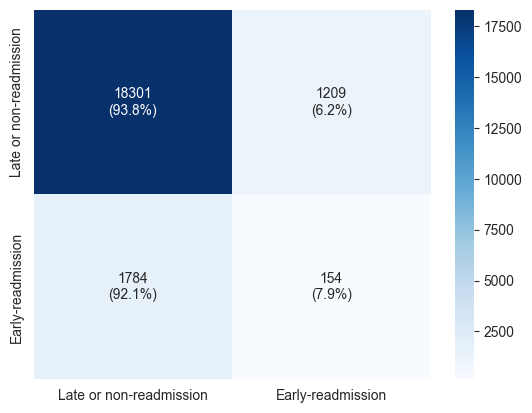

In [24]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [25]:
def objective(trial: optuna.Trial) -> float:
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 50),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        KNeighborsClassifier(**params)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [26]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 12:36:59,146] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [27]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-12 12:37:13,184] Trial 4 finished with value: 0.46619801516222453 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 2 with value: 0.4864421600147114.
[I 2025-01-12 12:37:13,186] Trial 0 finished with value: 0.4553173964100076 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 2 with value: 0.4864421600147114.


Cross validation scores: [0.45295045 0.4596795  0.46248158 0.44767969 0.44660986]
Average score: 0.4538802170853985
Cross validation scores: [0.46886931 0.47444951 0.47209671 0.46952746 0.46783601]
Average score: 0.47055579949821935
Cross validation scores: [0.48899167 0.48820347 0.49244092 0.48195232 0.48062242]
Average score: 0.4864421600147114
Cross validation scores: [0.45676226 0.45770754 0.45596627 0.45642026 0.44973066]
Average score: 0.4553173964100076
Cross validation scores: [0.49054717 0.49410262 0.48871734 0.48031534 0.48217366]
Average score: 0.4871712225741776
Cross validation scores: [0.47288338 0.46950289 0.46676947 0.45967199 0.46216235]
Average score: 0.46619801516222453


[I 2025-01-12 12:37:13,324] Trial 5 finished with value: 0.4871712225741776 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 5 with value: 0.4871712225741776.
[I 2025-01-12 12:37:13,327] Trial 2 finished with value: 0.4864421600147114 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 5 with value: 0.4871712225741776.
[I 2025-01-12 12:37:13,330] Trial 1 finished with value: 0.4538802170853985 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 5 with value: 0.4871712225741776.
[I 2025-01-12 12:37:13,450] Trial 3 finished with value: 0.47055579949821935 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 5 with value: 0.4871712225741776.
[I 2025-01-12 12:37:27,924] Trial 7 finished with value: 0.4878737271030918 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10

Cross validation scores: [0.5096576  0.51104784 0.509383   0.50434544 0.49204589]Cross validation scores: [0.4925364  0.49151256 0.48901296 0.48304373 0.48326298]
Average score: 0.4878737271030918

Average score: 0.5052959553628396
Cross validation scores: [0.47519473 0.47613683 0.46946176 0.46358763 0.46368641]
Average score: 0.4696134729430992
Cross validation scores: [0.45445227 0.46068328 0.45862061 0.45599889 0.45528503]
Average score: 0.45700801491557
Cross validation scores: [0.49364552 0.49247446 0.49132675 0.48683067 0.4847107 ]
Average score: 0.48979762035563484
Cross validation scores: [0.49452094 0.49163938 0.49159647 0.48726938 0.48140948]
Average score: 0.4892871281538437


[I 2025-01-12 12:37:28,041] Trial 10 finished with value: 0.5052959553628396 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:28,043] Trial 8 finished with value: 0.48979762035563484 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:28,099] Trial 9 finished with value: 0.4892871281538437 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:28,102] Trial 6 finished with value: 0.45700801491557 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:28,102] Trial 11 finished with value: 0.4696134729430992 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 

Cross validation scores: [0.43859274 0.44211372 0.44583138 0.44050561 0.43256991]
Average score: 0.439922671123294
Cross validation scores: [0.43859274 0.44211372 0.44583138 0.44050561 0.43256991]
Average score: 0.439922671123294
Cross validation scores: [0.43859274 0.44211372 0.44583138 0.44050561 0.43256991]
Average score: 0.439922671123294


[I 2025-01-12 12:37:30,901] Trial 17 finished with value: 0.439922671123294 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:30,948] Trial 14 finished with value: 0.439922671123294 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.


Cross validation scores: [0.4370021  0.43986103 0.44527993 0.43878634 0.42852102]
Average score: 0.4378900841655452


[I 2025-01-12 12:37:31,276] Trial 15 finished with value: 0.4378900841655452 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:31,441] Trial 16 finished with value: 0.43791482021817973 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.


Cross validation scores: [0.43505951 0.44105165 0.44470485 0.43770232 0.43105576]
Average score: 0.43791482021817973


[I 2025-01-12 12:37:36,403] Trial 12 finished with value: 0.4685597250513802 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.


Cross validation scores: [0.46782729 0.46873577 0.47528047 0.4688673  0.46208779]
Average score: 0.4685597250513802
Cross validation scores: [0.49296792 0.4908994  0.49674672 0.48090208 0.47687858]
Average score: 0.4876789376620054
Cross validation scores: [0.4925364  0.49151256 0.48901296 0.48304373 0.48326298]
Average score: 0.4878737271030918
Cross validation scores: [0.48186424 0.47974548 0.48019941 0.47740641 0.47471746]
Average score: 0.4787866023574526
Cross validation scores: [0.49547667 0.49016081 0.49133275 0.48733207 0.48482046]
Average score: 0.48982455151451026
Cross validation scores: [0.49278138 0.49346618 0.49369037 0.4871956  0.48225052]
Average score: 0.4898768120469931


[I 2025-01-12 12:37:45,216] Trial 21 finished with value: 0.4876789376620054 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:45,217] Trial 19 finished with value: 0.48982455151451026 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:45,219] Trial 18 finished with value: 0.4787866023574526 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:45,221] Trial 22 finished with value: 0.4898768120469931 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:37:45,222] Trial 20 finished with value: 0.4878737271030918 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'euclidean'}. Best is t

Cross validation scores: [0.47546548 0.48087656 0.47613465 0.47291006 0.47083155]
Average score: 0.4752436609562965
Cross validation scores: [0.48142339 0.48113677 0.48407784 0.47853141 0.47212471]
Average score: 0.4794588247256558
Cross validation scores: [0.493238   0.49215875 0.4930852  0.48684031 0.48335129]
Average score: 0.4897347103896423
Cross validation scores: [0.493238   0.49215875 0.4930852  0.48684031 0.48335129]
Average score: 0.4897347103896423
Cross validation scores: [0.49547667 0.49016081 0.49133275 0.48733207 0.48482046]
Average score: 0.48982455151451026
Cross validation scores: [0.493238   0.49215875 0.4930852  0.48684031 0.48335129]
Average score: 0.4897347103896423


[I 2025-01-12 12:38:01,707] Trial 24 finished with value: 0.4897347103896423 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:01,709] Trial 28 finished with value: 0.48982455151451026 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:01,757] Trial 25 finished with value: 0.4897347103896423 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:01,758] Trial 26 finished with value: 0.4794588247256558 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:01,764] Trial 27 finished with value: 0.4897347103896423 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'metric': 'euclidean'}. Best is 

Cross validation scores: [0.49366684 0.49278804 0.49228503 0.48926397 0.48547316]
Average score: 0.49069540683670015


[I 2025-01-12 12:38:02,848] Trial 29 finished with value: 0.49069540683670015 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:15,348] Trial 33 finished with value: 0.4876789376620054 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:15,390] Trial 32 finished with value: 0.48399632243313917 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:15,392] Trial 31 finished with value: 0.47803307363432496 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.


Cross validation scores: [0.49296792 0.4908994  0.49674672 0.48090208 0.47687858]
Average score: 0.4876789376620054
Cross validation scores: [0.48433023 0.48739587 0.49158817 0.47986758 0.47679976]
Average score: 0.48399632243313917
Cross validation scores: [0.47588798 0.48026729 0.4740936  0.47302436 0.47126994]
Average score: 0.4749086328489933
Cross validation scores: [0.4940212  0.48808907 0.49184938 0.47938488 0.47644142]
Average score: 0.4859571877683
Cross validation scores: [0.47935853 0.47968093 0.48106595 0.47709779 0.47296218]
Average score: 0.47803307363432496
Cross validation scores: [0.46051776 0.46620143 0.46909437 0.46020271 0.45932164]
Average score: 0.46306758047643576


[I 2025-01-12 12:38:15,573] Trial 35 finished with value: 0.46306758047643576 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:15,575] Trial 34 finished with value: 0.4859571877683 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:15,576] Trial 30 finished with value: 0.4749086328489933 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:31,015] Trial 36 finished with value: 0.4777033022488425 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.


Cross validation scores: [0.49366684 0.49278804 0.49228503 0.48926397 0.48547316]
Average score: 0.49069540683670015
Cross validation scores: [0.48797091 0.49297505 0.48718422 0.47729066 0.47929208]
Average score: 0.48494258336942336
Cross validation scores: [0.482132   0.47763201 0.47902464 0.47591074 0.47381712]
Average score: 0.4777033022488425
Cross validation scores: [0.48797091 0.49297505 0.48718422 0.47729066 0.47929208]
Average score: 0.48494258336942336
Cross validation scores: [0.48906961 0.49161847 0.48738341 0.48103897 0.48399738]
Average score: 0.48662156814692875
Cross validation scores: [0.49366684 0.49278804 0.49228503 0.48926397 0.48547316]
Average score: 0.49069540683670015


[I 2025-01-12 12:38:31,088] Trial 38 finished with value: 0.48494258336942336 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:31,123] Trial 40 finished with value: 0.48494258336942336 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:31,125] Trial 41 finished with value: 0.49069540683670015 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:31,165] Trial 39 finished with value: 0.49069540683670015 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:31,240] Trial 37 finished with value: 0.48662156814692875 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'euclidean'}. Best

Cross validation scores: [0.49073412 0.49218211 0.48937969 0.48163225 0.48152162]
Average score: 0.48708995890188395
Cross validation scores: [0.48433023 0.48739587 0.49158817 0.47986758 0.47679976]
Average score: 0.48399632243313917
Cross validation scores: [0.49366684 0.49278804 0.49228503 0.48926397 0.48547316]
Average score: 0.49069540683670015
Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877
Cross validation scores: [0.49278138 0.49346618 0.49369037 0.4871956  0.48225052]
Average score: 0.4898768120469931
Cross validation scores: [0.49366684 0.49278804 0.49228503 0.48926397 0.48547316]
Average score: 0.49069540683670015


[I 2025-01-12 12:38:46,865] Trial 43 finished with value: 0.49069540683670015 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:46,866] Trial 42 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:46,868] Trial 45 finished with value: 0.49069540683670015 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:46,870] Trial 46 finished with value: 0.48708995890188395 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:46,956] Trial 47 finished with value: 0.48399632243313917 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'euclidean'}. Best 

Cross validation scores: [0.47097335 0.47321708 0.46686882 0.46102295 0.46504769]
Average score: 0.4674259769699655
Cross validation scores: [0.4743086  0.47745869 0.46904986 0.46506675 0.46612506]
Average score: 0.4704017948667804
Cross validation scores: [0.47097335 0.47321708 0.46686882 0.46102295 0.46504769]
Average score: 0.4674259769699655
Cross validation scores: [0.47781825 0.47948816 0.47682589 0.4761586  0.47231757]
Average score: 0.4765216918855016
Cross validation scores: [0.46275082 0.46586676 0.46888285 0.45594201 0.45437272]
Average score: 0.46156303049409536
Cross validation scores: [0.46349983 0.46731472 0.47132143 0.4640807  0.4611767 ]
Average score: 0.4654786748232513


[I 2025-01-12 12:38:58,943] Trial 49 finished with value: 0.4704017948667804 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:58,945] Trial 52 finished with value: 0.4674259769699655 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:59,076] Trial 53 finished with value: 0.4654786748232513 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:59,078] Trial 50 finished with value: 0.4765216918855016 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:38:59,080] Trial 51 finished with value: 0.4674259769699655 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'minkowski'}. Best is 

Cross validation scores: [0.47586222 0.47893143 0.47394444 0.47050105 0.46940333]Cross validation scores: [0.482132   0.47763201 0.47902464 0.47591074 0.47381712]
Average score: 0.4777033022488425
Cross validation scores: [0.47586222 0.47893143 0.47394444 0.47050105 0.46940333]
Average score: 0.4737284926822172

Average score: 0.4737284926822172
Cross validation scores: [0.49452094 0.49163938 0.49159647 0.48726938 0.48140948]
Average score: 0.4892871281538437
Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877
Cross validation scores: [0.47586222 0.47893143 0.47394444 0.47050105 0.46940333]
Average score: 0.4737284926822172


[I 2025-01-12 12:39:15,059] Trial 58 finished with value: 0.4892871281538437 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:15,061] Trial 57 finished with value: 0.4737284926822172 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:15,369] Trial 59 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:15,478] Trial 55 finished with value: 0.4737284926822172 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:28,659] Trial 65 finished with value: 0.4696134729430992 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'euclidean'}. Best is t

Cross validation scores: [0.47519473 0.47613683 0.46946176 0.46358763 0.46368641]
Average score: 0.4696134729430992
Cross validation scores: [0.4855458  0.48434266 0.49090793 0.48206535 0.47488624]
Average score: 0.4835495957920224
Cross validation scores: [0.47603071 0.48043909 0.47409609 0.47625007 0.47217182]
Average score: 0.4757975550700655
Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877
Cross validation scores: [0.46526177 0.46677637 0.46965941 0.45995913 0.45764618]
Average score: 0.4638605709934643
Cross validation scores: [0.49364552 0.49247446 0.49132675 0.48683067 0.4847107 ]
Average score: 0.48979762035563484


[I 2025-01-12 12:39:28,792] Trial 64 finished with value: 0.4835495957920224 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:28,794] Trial 62 finished with value: 0.4638605709934643 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:28,834] Trial 60 finished with value: 0.48979762035563484 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:28,876] Trial 63 finished with value: 0.4757975550700655 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:28,918] Trial 61 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is

Cross validation scores: [0.47781825 0.47948816 0.47682589 0.4761586  0.47231757]
Average score: 0.4765216918855016
Cross validation scores: [0.4749308  0.47929602 0.47282719 0.46873981 0.4681914 ]
Average score: 0.47279704293899716
Cross validation scores: [0.47781825 0.47948816 0.47682589 0.4761586  0.47231757]
Average score: 0.4765216918855016
Cross validation scores: [0.47935853 0.47968093 0.48106595 0.47709779 0.47296218]
Average score: 0.47803307363432496
Cross validation scores: [0.49278138 0.49346618 0.49369037 0.4871956  0.48225052]
Average score: 0.4898768120469931
Cross validation scores: [0.4749308  0.47929602 0.47282719 0.46873981 0.4681914 ]
Average score: 0.47279704293899716


[I 2025-01-12 12:39:44,842] Trial 66 finished with value: 0.4765216918855016 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:44,844] Trial 68 finished with value: 0.4765216918855016 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:44,845] Trial 69 finished with value: 0.47279704293899716 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:44,847] Trial 70 finished with value: 0.47803307363432496 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:39:45,009] Trial 71 finished with value: 0.4898768120469931 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'euclidean'}. Best is

Cross validation scores: [0.482132   0.47763201 0.47902464 0.47591074 0.47381712]
Average score: 0.4777033022488425
Cross validation scores: [0.482132   0.47763201 0.47902464 0.47591074 0.47381712]
Average score: 0.4777033022488425
Cross validation scores: [0.47546548 0.48087656 0.47613465 0.47291006 0.47083155]
Average score: 0.4752436609562965
Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877
Cross validation scores: [0.482132   0.47763201 0.47902464 0.47591074 0.47381712]
Average score: 0.4777033022488425
Cross validation scores: [0.49452094 0.49163938 0.49159647 0.48726938 0.48140948]
Average score: 0.4892871281538437


[I 2025-01-12 12:40:01,111] Trial 72 finished with value: 0.4777033022488425 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:01,112] Trial 76 finished with value: 0.4752436609562965 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:01,114] Trial 75 finished with value: 0.4892871281538437 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:01,115] Trial 77 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:01,117] Trial 74 finished with value: 0.4777033022488425 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'euclidean'}. Best is t

Cross validation scores: [0.4426004  0.4405125  0.44809903 0.44059481 0.43099132]
Average score: 0.4405596125205218


[I 2025-01-12 12:40:12,258] Trial 78 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.


Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877
Cross validation scores: [0.48186424 0.47974548 0.48019941 0.47740641 0.47471746]
Average score: 0.4787866023574526
Cross validation scores: [0.47781825 0.47948816 0.47682589 0.4761586  0.47231757]
Average score: 0.4765216918855016
Cross validation scores: [0.46014769 0.46512697 0.46859227 0.4596307  0.45788524]
Average score: 0.46227657476765743
Cross validation scores: [0.46051776 0.46620143 0.46909437 0.46020271 0.45932164]
Average score: 0.46306758047643576


[I 2025-01-12 12:40:12,260] Trial 80 finished with value: 0.4765216918855016 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:12,262] Trial 83 finished with value: 0.4787866023574526 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:12,263] Trial 79 finished with value: 0.46306758047643576 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:12,265] Trial 81 finished with value: 0.46227657476765743 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:19,232] Trial 84 finished with value: 0.48979762035563484 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'metric': 'minkowski'}. Best

Cross validation scores: [0.49364552 0.49247446 0.49132675 0.48683067 0.4847107 ]
Average score: 0.48979762035563484
Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877
Cross validation scores: [0.49073412 0.49218211 0.48937969 0.48163225 0.48152162]
Average score: 0.48708995890188395
Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877
Cross validation scores: [0.4925364  0.49151256 0.48901296 0.48304373 0.48326298]
Average score: 0.4878737271030918
Cross validation scores: [0.49366684 0.49278804 0.49228503 0.48926397 0.48547316]
Average score: 0.49069540683670015


[I 2025-01-12 12:40:28,275] Trial 86 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:28,277] Trial 87 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:28,325] Trial 89 finished with value: 0.48708995890188395 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:28,327] Trial 85 finished with value: 0.4878737271030918 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:28,457] Trial 88 finished with value: 0.49069540683670015 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean'}. Best is

Cross validation scores: [0.48401861 0.48610855 0.48816405 0.47795301 0.47881255]
Average score: 0.48301135382636806


[I 2025-01-12 12:40:30,700] Trial 90 finished with value: 0.48301135382636806 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.


Cross validation scores: [0.4743086  0.47745869 0.46904986 0.46506675 0.46612506]
Average score: 0.4704017948667804
Cross validation scores: [0.48906961 0.49161847 0.48738341 0.48103897 0.48399738]
Average score: 0.48662156814692875
Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877
Cross validation scores: [0.47546548 0.48087656 0.47613465 0.47291006 0.47083155]
Average score: 0.4752436609562965
Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877


[I 2025-01-12 12:40:44,058] Trial 92 finished with value: 0.4704017948667804 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:44,060] Trial 95 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:44,134] Trial 94 finished with value: 0.48662156814692875 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:44,136] Trial 93 finished with value: 0.4752436609562965 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:44,208] Trial 91 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is 

Cross validation scores: [0.47586222 0.47893143 0.47394444 0.47050105 0.46940333]
Average score: 0.4737284926822172


[I 2025-01-12 12:40:52,291] Trial 98 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.


Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877


[I 2025-01-12 12:40:53,743] Trial 97 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.
[I 2025-01-12 12:40:53,744] Trial 99 finished with value: 0.4906990037872877 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 10 with value: 0.5052959553628396.


Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877
Cross validation scores: [0.49357604 0.49565957 0.49342861 0.48677781 0.48405299]
Average score: 0.4906990037872877


In [28]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 10
Best Parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean'}
Best Value: 0.5052959553628396


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [29]:
optuna.visualization.plot_optimization_history(study)

In [30]:
optuna.visualization.plot_slice(study)

In [31]:
optuna.visualization.plot_param_importances(study)

In [32]:
optuna.visualization.plot_parallel_coordinate(study)

In [33]:
optuna.visualization.plot_contour(study)

In [34]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [35]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    KNeighborsClassifier(**best_params)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=2))])

In [36]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [37]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.7763013288040763
Test accuracy:  0.7349869451697127


In [38]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.78      0.84     19510
      Early-readmission       0.11      0.27      0.16      1938

               accuracy                           0.73     21448
              macro avg       0.51      0.53      0.50     21448
           weighted avg       0.84      0.73      0.78     21448



In [39]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

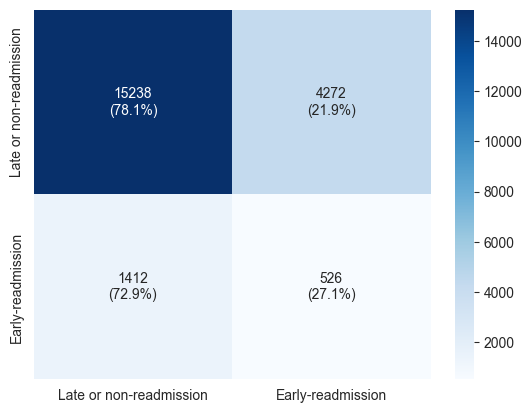

In [40]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [41]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 50),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        KNeighborsClassifier(**params)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [42]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 12:40:59,708] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [43]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-12 12:41:10,943] Trial 1 finished with value: 0.5186698844566948 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 1 with value: 0.5186698844566948.


Cross validation scores: [0.51716759 0.51450263 0.52109786 0.52003442 0.52054692]
Average score: 0.5186698844566948


[I 2025-01-12 12:41:13,842] Trial 4 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:41:19,175] Trial 0 finished with value: 0.47525132661802505 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.4713156  0.48110337 0.47254779 0.47736383 0.47392605]
Average score: 0.47525132661802505


[I 2025-01-12 12:41:27,101] Trial 2 finished with value: 0.5079463085758578 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.5022828  0.5108247  0.5120082  0.5087284  0.50588744]
Average score: 0.5079463085758578


[I 2025-01-12 12:41:29,184] Trial 5 finished with value: 0.4480923294752043 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.4429443  0.45010826 0.44835741 0.4543874  0.44466428]
Average score: 0.4480923294752043


[I 2025-01-12 12:41:32,176] Trial 3 finished with value: 0.5210749553924993 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51986629 0.52624322 0.52535617 0.51978435 0.51412474]
Average score: 0.5210749553924993


[I 2025-01-12 12:41:34,507] Trial 7 finished with value: 0.5106617934895105 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.50795487 0.51451196 0.51180982 0.5104035  0.50862882]
Average score: 0.5106617934895105


[I 2025-01-12 12:41:34,844] Trial 6 finished with value: 0.45489773709266 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.45167535 0.45738991 0.45951653 0.45544218 0.45046471]
Average score: 0.45489773709266


[I 2025-01-12 12:41:48,692] Trial 8 finished with value: 0.4766147415040405 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.475078   0.48180142 0.47869154 0.4813286  0.46617415]
Average score: 0.4766147415040405


[I 2025-01-12 12:41:52,759] Trial 10 finished with value: 0.5086067542948978 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.50526432 0.51179618 0.51212521 0.50739485 0.50645322]
Average score: 0.5086067542948978


[I 2025-01-12 12:41:56,593] Trial 9 finished with value: 0.5203116478056508 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.517465   0.52383721 0.52687337 0.52075315 0.5126295 ]
Average score: 0.5203116478056508
Cross validation scores: [0.50208798 0.51265153 0.51199009 0.5080258  0.5054623 ]
Average score: 0.5080435391039421


[I 2025-01-12 12:42:00,021] Trial 12 finished with value: 0.5080435391039421 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:42:02,009] Trial 11 finished with value: 0.4841367486703496 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.48326704 0.48916373 0.48487387 0.48902117 0.47435793]
Average score: 0.4841367486703496
Cross validation scores: [0.51601679 0.51924699 0.51811811 0.51835411 0.51745478]
Average score: 0.5178381555147515


[I 2025-01-12 12:42:03,179] Trial 14 finished with value: 0.5178381555147515 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:42:06,024] Trial 13 finished with value: 0.4789497629741577 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.4771015  0.48350592 0.47765113 0.48473284 0.47175742]
Average score: 0.4789497629741577


[I 2025-01-12 12:42:09,275] Trial 17 finished with value: 0.5205788958715547 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51701453 0.52125564 0.52571848 0.52223101 0.51667481]
Average score: 0.5205788958715547


[I 2025-01-12 12:42:12,463] Trial 15 finished with value: 0.5207258086341825 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51958618 0.52096736 0.52433577 0.51812284 0.52061689]
Average score: 0.5207258086341825
Cross validation scores: [0.51703449 0.5244464  0.52374344 0.52003811 0.51664072]
Average score: 0.5203806341178646


[I 2025-01-12 12:42:21,887] Trial 16 finished with value: 0.5203806341178646 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:42:25,800] Trial 21 finished with value: 0.5236570882060595 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52162872 0.52345491 0.52729295 0.52413687 0.52177199]
Average score: 0.5236570882060595


[I 2025-01-12 12:42:27,877] Trial 20 finished with value: 0.520009939017011 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51864966 0.52069748 0.52266283 0.51985164 0.51818809]
Average score: 0.520009939017011
Cross validation scores: [0.5177027  0.5247118  0.51956279 0.52151991 0.51672995]
Average score: 0.5200454300936675


[I 2025-01-12 12:42:28,556] Trial 18 finished with value: 0.5200454300936675 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.5201866  0.52387632 0.52519099 0.51876986 0.51393713]
Average score: 0.5203921804428948


[I 2025-01-12 12:42:34,173] Trial 19 finished with value: 0.5203921804428948 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51645109 0.52380868 0.52565376 0.52075235 0.5167601 ]
Average score: 0.520685197153496


[I 2025-01-12 12:42:35,066] Trial 22 finished with value: 0.520685197153496 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:42:41,050] Trial 25 finished with value: 0.5253722418213709 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52316164 0.52387901 0.52975535 0.52759293 0.52247227]
Average score: 0.5253722418213709


[I 2025-01-12 12:42:43,267] Trial 24 finished with value: 0.4985448937779239 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.49585433 0.49920954 0.49963401 0.49838329 0.49964329]
Average score: 0.4985448937779239


[I 2025-01-12 12:42:46,000] Trial 27 finished with value: 0.5246391621913785 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52226111 0.5259457  0.52914521 0.52141924 0.52442455]
Average score: 0.5246391621913785


[I 2025-01-12 12:42:47,766] Trial 26 finished with value: 0.521538529441113 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.5190916  0.52139909 0.52630562 0.51958329 0.52131305]
Average score: 0.521538529441113


[I 2025-01-12 12:42:52,006] Trial 23 finished with value: 0.520834221010158 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51816255 0.52549438 0.5269495  0.5199186  0.51364607]
Average score: 0.520834221010158


[I 2025-01-12 12:42:54,858] Trial 28 finished with value: 0.5203954722649793 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52040449 0.52099746 0.52397996 0.51794021 0.51865524]
Average score: 0.5203954722649793
Cross validation scores: [0.52150816 0.52306729 0.52746974 0.52539169 0.52166768]
Average score: 0.5238209123269344


[I 2025-01-12 12:42:56,624] Trial 29 finished with value: 0.5238209123269344 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52316164 0.52387901 0.52975535 0.52759293 0.52247227]
Average score: 0.5253722418213709


[I 2025-01-12 12:42:57,318] Trial 30 finished with value: 0.5253722418213709 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:42:58,907] Trial 31 finished with value: 0.5226025785793518 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52355895 0.51844489 0.52653861 0.5195098  0.52496064]
Average score: 0.5226025785793518
Cross validation scores: [0.51421051 0.5090852  0.5172742  0.51338527 0.51003891]
Average score: 0.5127988174678101


[I 2025-01-12 12:43:01,679] Trial 32 finished with value: 0.5127988174678101 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52036684 0.52237716 0.53016158 0.5252846  0.52123764]
Average score: 0.5238855643014837


[I 2025-01-12 12:43:07,501] Trial 34 finished with value: 0.5238855643014837 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:43:07,598] Trial 35 finished with value: 0.5229457697124547 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.5213662  0.52162127 0.53025189 0.52150655 0.51998292]
Average score: 0.5229457697124547
Cross validation scores: [0.51266836 0.5170992  0.5107764  0.51846424 0.51582188]
Average score: 0.5149660152272493


[I 2025-01-12 12:43:09,791] Trial 33 finished with value: 0.5149660152272493 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:43:11,329] Trial 36 finished with value: 0.5238855643014837 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52036684 0.52237716 0.53016158 0.5252846  0.52123764]
Average score: 0.5238855643014837
Cross validation scores: [0.52036684 0.52237716 0.53016158 0.5252846  0.52123764]
Average score: 0.5238855643014837


[I 2025-01-12 12:43:11,965] Trial 37 finished with value: 0.5238855643014837 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51880014 0.52283513 0.52656449 0.52136882 0.52060392]
Average score: 0.5220344984454102


[I 2025-01-12 12:43:18,361] Trial 38 finished with value: 0.5220344984454102 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:43:21,495] Trial 42 finished with value: 0.5186698844566948 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51716759 0.51450263 0.52109786 0.52003442 0.52054692]
Average score: 0.5186698844566948


[I 2025-01-12 12:43:23,730] Trial 39 finished with value: 0.5151403985010262 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51269531 0.51623098 0.51335488 0.51650763 0.5169132 ]
Average score: 0.5151403985010262


[I 2025-01-12 12:43:24,542] Trial 41 finished with value: 0.5253722418213709 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52316164 0.52387901 0.52975535 0.52759293 0.52247227]
Average score: 0.5253722418213709


[I 2025-01-12 12:43:31,304] Trial 40 finished with value: 0.49325720332948586 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.49012726 0.49272672 0.49892824 0.4929076  0.4915962 ]
Average score: 0.49325720332948586
Cross validation scores: [0.49463331 0.50024714 0.504056   0.49982085 0.4961751 ]
Average score: 0.49898648142343854


[I 2025-01-12 12:43:33,363] Trial 43 finished with value: 0.49898648142343854 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52226111 0.5259457  0.52914521 0.52141924 0.52442455]
Average score: 0.5246391621913785


[I 2025-01-12 12:43:35,389] Trial 45 finished with value: 0.5246391621913785 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52036684 0.52237716 0.53016158 0.5252846  0.52123764]
Average score: 0.5238855643014837


[I 2025-01-12 12:43:37,152] Trial 46 finished with value: 0.5238855643014837 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:43:39,025] Trial 47 finished with value: 0.5239294470348635 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52138513 0.5212397  0.52827277 0.52498894 0.52376069]
Average score: 0.5239294470348635


[I 2025-01-12 12:43:41,013] Trial 44 finished with value: 0.5107619257814218 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.50662737 0.5143336  0.51422848 0.50959556 0.50902462]
Average score: 0.5107619257814218


[I 2025-01-12 12:43:48,050] Trial 49 finished with value: 0.5253722418213709 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52316164 0.52387901 0.52975535 0.52759293 0.52247227]
Average score: 0.5253722418213709


[I 2025-01-12 12:43:48,727] Trial 48 finished with value: 0.5220344984454102 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51880014 0.52283513 0.52656449 0.52136882 0.52060392]
Average score: 0.5220344984454102


[I 2025-01-12 12:43:50,118] Trial 53 finished with value: 0.5205788958715547 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51701453 0.52125564 0.52571848 0.52223101 0.51667481]
Average score: 0.5205788958715547


[I 2025-01-12 12:43:56,573] Trial 51 finished with value: 0.5118411399779633 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.50704222 0.51509772 0.51165866 0.51454524 0.51086186]
Average score: 0.5118411399779633


[I 2025-01-12 12:43:58,528] Trial 52 finished with value: 0.5057654312223148 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.50054909 0.50851569 0.51279495 0.50374799 0.50321943]
Average score: 0.5057654312223148


[I 2025-01-12 12:44:01,210] Trial 54 finished with value: 0.5253722418213709 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52316164 0.52387901 0.52975535 0.52759293 0.52247227]
Average score: 0.5253722418213709
Cross validation scores: [0.51848996 0.52430789 0.52146203 0.52206771 0.51732016]
Average score: 0.5207295511200525


[I 2025-01-12 12:44:01,724] Trial 50 finished with value: 0.5207295511200525 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:44:02,130] Trial 56 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:44:03,827] Trial 55 finished with value: 0.5238209123269344 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52150816 0.52306729 0.52746974 0.52539169 0.52166768]
Average score: 0.5238209123269344


[I 2025-01-12 12:44:11,699] Trial 57 finished with value: 0.5239294470348635 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52138513 0.5212397  0.52827277 0.52498894 0.52376069]
Average score: 0.5239294470348635


[I 2025-01-12 12:44:14,070] Trial 58 finished with value: 0.5236570882060595 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52162872 0.52345491 0.52729295 0.52413687 0.52177199]
Average score: 0.5236570882060595


[I 2025-01-12 12:44:14,992] Trial 59 finished with value: 0.5253722418213709 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52316164 0.52387901 0.52975535 0.52759293 0.52247227]
Average score: 0.5253722418213709


[I 2025-01-12 12:44:15,367] Trial 61 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:44:20,200] Trial 60 finished with value: 0.521538529441113 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.5190916  0.52139909 0.52630562 0.51958329 0.52131305]
Average score: 0.521538529441113


[I 2025-01-12 12:44:27,042] Trial 62 finished with value: 0.510549250168297 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:44:27,044] Trial 64 finished with value: 0.5225354286471287 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.50595995 0.51365589 0.51402441 0.51098507 0.50812094]
Average score: 0.510549250168297
Cross validation scores: [0.52132073 0.52061034 0.52300668 0.52318193 0.52455745]
Average score: 0.5225354286471287


[I 2025-01-12 12:44:28,153] Trial 66 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:44:28,914] Trial 67 finished with value: 0.5205788958715547 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51701453 0.52125564 0.52571848 0.52223101 0.51667481]
Average score: 0.5205788958715547


[I 2025-01-12 12:44:30,269] Trial 63 finished with value: 0.49931941164994564 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.49680828 0.5002806  0.50673727 0.49817441 0.49459649]
Average score: 0.49931941164994564


[I 2025-01-12 12:44:40,054] Trial 70 finished with value: 0.5246391621913785 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52226111 0.5259457  0.52914521 0.52141924 0.52442455]
Average score: 0.5246391621913785


[I 2025-01-12 12:44:40,835] Trial 71 finished with value: 0.5246391621913785 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:44:40,838] Trial 68 finished with value: 0.5253722418213709 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52226111 0.5259457  0.52914521 0.52141924 0.52442455]
Average score: 0.5246391621913785
Cross validation scores: [0.52316164 0.52387901 0.52975535 0.52759293 0.52247227]
Average score: 0.5253722418213709
Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513
Cross validation scores: [0.52316164 0.52387901 0.52975535 0.52759293 0.52247227]
Average score: 0.5253722418213709


[I 2025-01-12 12:44:41,952] Trial 72 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:44:41,954] Trial 69 finished with value: 0.5253722418213709 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:44:43,061] Trial 65 finished with value: 0.5206298116018979 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51906806 0.52372716 0.52528685 0.5217169  0.5133501 ]
Average score: 0.5206298116018979


[I 2025-01-12 12:44:51,548] Trial 75 finished with value: 0.5215020725135506 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52230671 0.51564689 0.52347272 0.52054222 0.52554182]
Average score: 0.5215020725135506
Cross validation scores: [0.52036684 0.52237716 0.53016158 0.5252846  0.52123764]
Average score: 0.5238855643014837


[I 2025-01-12 12:44:54,409] Trial 76 finished with value: 0.5238855643014837 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:44:55,640] Trial 73 finished with value: 0.5220344984454102 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:44:55,716] Trial 78 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51880014 0.52283513 0.52656449 0.52136882 0.52060392]
Average score: 0.5220344984454102
Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:44:56,009] Trial 74 finished with value: 0.5173075901770862 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51761315 0.51734345 0.5150565  0.51742024 0.5191046 ]
Average score: 0.5173075901770862


[I 2025-01-12 12:44:56,455] Trial 77 finished with value: 0.5238855643014837 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52036684 0.52237716 0.53016158 0.5252846  0.52123764]
Average score: 0.5238855643014837


[I 2025-01-12 12:45:01,970] Trial 79 finished with value: 0.5229457697124547 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.5213662  0.52162127 0.53025189 0.52150655 0.51998292]
Average score: 0.5229457697124547


[I 2025-01-12 12:45:05,093] Trial 81 finished with value: 0.5205788958715547 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51701453 0.52125564 0.52571848 0.52223101 0.51667481]
Average score: 0.5205788958715547


[I 2025-01-12 12:45:08,775] Trial 80 finished with value: 0.521952688458941 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52169516 0.52444324 0.52821893 0.51992599 0.51548013]
Average score: 0.521952688458941


[I 2025-01-12 12:45:09,417] Trial 82 finished with value: 0.5225354286471287 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52132073 0.52061034 0.52300668 0.52318193 0.52455745]
Average score: 0.5225354286471287


[I 2025-01-12 12:45:12,745] Trial 83 finished with value: 0.5238209123269344 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52150816 0.52306729 0.52746974 0.52539169 0.52166768]
Average score: 0.5238209123269344
Cross validation scores: [0.52197395 0.52346535 0.52837444 0.52168291 0.52073869]
Average score: 0.5232470677760137


[I 2025-01-12 12:45:14,216] Trial 84 finished with value: 0.5232470677760137 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:45:14,219] Trial 85 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:45:19,202] Trial 86 finished with value: 0.5239294470348635 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52138513 0.5212397  0.52827277 0.52498894 0.52376069]
Average score: 0.5239294470348635


[I 2025-01-12 12:45:19,756] Trial 87 finished with value: 0.5229457697124547 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.5213662  0.52162127 0.53025189 0.52150655 0.51998292]
Average score: 0.5229457697124547


[I 2025-01-12 12:45:23,764] Trial 88 finished with value: 0.5239294470348635 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52138513 0.5212397  0.52827277 0.52498894 0.52376069]
Average score: 0.5239294470348635


[I 2025-01-12 12:45:25,362] Trial 89 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513
Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:45:27,169] Trial 90 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.
[I 2025-01-12 12:45:27,826] Trial 91 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:45:32,409] Trial 92 finished with value: 0.5219266686847581 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51916676 0.52094331 0.53094991 0.52051019 0.51806317]
Average score: 0.5219266686847581


[I 2025-01-12 12:45:36,763] Trial 93 finished with value: 0.5225181269540645 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.51759477 0.52558116 0.52550991 0.52163012 0.52227467]
Average score: 0.5225181269540645


[I 2025-01-12 12:45:37,015] Trial 95 finished with value: 0.5246391621913785 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52226111 0.5259457  0.52914521 0.52141924 0.52442455]
Average score: 0.5246391621913785


[I 2025-01-12 12:45:39,809] Trial 96 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:45:40,259] Trial 97 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:45:42,784] Trial 98 finished with value: 0.5255936103262513 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52310748 0.52747935 0.52871027 0.52396406 0.5247069 ]
Average score: 0.5255936103262513


[I 2025-01-12 12:45:45,557] Trial 94 finished with value: 0.5196278064405926 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.5175754  0.52530477 0.52114756 0.51946314 0.51464816]
Average score: 0.5196278064405926


[I 2025-01-12 12:45:47,373] Trial 99 finished with value: 0.5236570882060595 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5255936103262513.


Cross validation scores: [0.52162872 0.52345491 0.52729295 0.52413687 0.52177199]
Average score: 0.5236570882060595


In [44]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 4
Best Parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}
Best Value: 0.5255936103262513


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [45]:
optuna.visualization.plot_optimization_history(study)

In [46]:
optuna.visualization.plot_slice(study)

In [47]:
optuna.visualization.plot_param_importances(study)

In [48]:
optuna.visualization.plot_parallel_coordinate(study)

In [49]:
optuna.visualization.plot_contour(study)

In [50]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [51]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"
    
pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    KNeighborsClassifier(**best_params)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=4,
                                      weights='distance'))])

In [52]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [53]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.9653112199020881
Test accuracy:  0.8135024244684819


In [54]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.88      0.90     19510
      Early-readmission       0.11      0.15      0.13      1938

               accuracy                           0.81     21448
              macro avg       0.51      0.52      0.51     21448
           weighted avg       0.84      0.81      0.83     21448



In [55]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

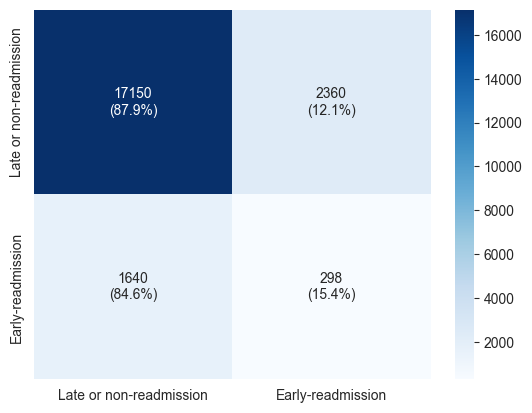

In [56]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [68]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 50),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        KNeighborsClassifier(**params)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [69]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

d:\VSCode_Workspaces\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-12 13:48:40,950] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [70]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

Cross validation scores: [0.47700808 0.4816141  0.48184485 0.48112318 0.48076859]
Average score: 0.4804717591964135
Cross validation scores: [0.51962314 0.51462321 0.5219345  0.51609539 0.51990751]
Average score: 0.5184367492706192


[I 2025-01-12 13:49:43,499] Trial 0 finished with value: 0.4804717591964135 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 5 with value: 0.5184367492706192.
[I 2025-01-12 13:49:43,500] Trial 5 finished with value: 0.5184367492706192 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5184367492706192.
[I 2025-01-12 13:49:51,123] Trial 3 finished with value: 0.5060206767787263 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5184367492706192.


Cross validation scores: [0.50338929 0.50721993 0.51042541 0.50692804 0.50214072]
Average score: 0.5060206767787263


[I 2025-01-12 13:49:52,497] Trial 4 finished with value: 0.5044249269102717 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5184367492706192.


Cross validation scores: [0.50012221 0.50576218 0.50916508 0.5046694  0.50240576]
Average score: 0.5044249269102717


[I 2025-01-12 13:49:53,122] Trial 2 finished with value: 0.44956774449578046 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5184367492706192.


Cross validation scores: [0.44252868 0.45171323 0.45160944 0.45582398 0.44616339]
Average score: 0.44956774449578046


[I 2025-01-12 13:49:55,541] Trial 1 finished with value: 0.5031907750487175 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 5 with value: 0.5184367492706192.


Cross validation scores: [0.50103163 0.50443189 0.50661291 0.50237916 0.50149828]
Average score: 0.5031907750487175
Cross validation scores: [0.51528435 0.51545101 0.51468969 0.51515839 0.51554695]
Average score: 0.515226079086527


[I 2025-01-12 13:50:41,505] Trial 6 finished with value: 0.515226079086527 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5184367492706192.
[I 2025-01-12 13:50:47,864] Trial 7 finished with value: 0.4636400672257417 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5184367492706192.


Cross validation scores: [0.46066345 0.4640127  0.47013466 0.4655253  0.45786423]
Average score: 0.4636400672257417


[I 2025-01-12 13:50:54,541] Trial 11 finished with value: 0.5187100037615567 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.51747019 0.51884198 0.52391186 0.51784525 0.51548074]
Average score: 0.5187100037615567


[I 2025-01-12 13:50:55,265] Trial 9 finished with value: 0.5077515601972237 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 11 with value: 0.5187100037615567.
[I 2025-01-12 13:50:55,267] Trial 8 finished with value: 0.5070870083591952 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.50366311 0.50904675 0.51130897 0.50977184 0.50496712]
Average score: 0.5077515601972237
Cross validation scores: [0.50311573 0.50808673 0.51167406 0.50881271 0.50374582]
Average score: 0.5070870083591952


[I 2025-01-12 13:51:00,468] Trial 10 finished with value: 0.4512019608946357 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.44477078 0.45309361 0.4515705  0.45944581 0.44712911]
Average score: 0.4512019608946357
Cross validation scores: [0.51578644 0.51925406 0.52378874 0.52022763 0.51386938]
Average score: 0.5185852489979494


[I 2025-01-12 13:51:45,973] Trial 15 finished with value: 0.5185852489979494 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.4408248  0.44616048 0.4427232  0.44849216 0.44030191]
Average score: 0.44370051007201344
Cross validation scores: [0.45848718 0.46392669 0.46835575 0.4661223  0.45619499]
Average score: 0.4626173814428875


[I 2025-01-12 13:51:52,229] Trial 13 finished with value: 0.4626173814428875 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 11 with value: 0.5187100037615567.
[I 2025-01-12 13:51:52,231] Trial 12 finished with value: 0.44370051007201344 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 11 with value: 0.5187100037615567.
[I 2025-01-12 13:51:54,958] Trial 16 finished with value: 0.5187100037615567 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.51747019 0.51884198 0.52391186 0.51784525 0.51548074]
Average score: 0.5187100037615567


[I 2025-01-12 13:51:57,321] Trial 14 finished with value: 0.4636400672257417 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.46066345 0.4640127  0.47013466 0.4655253  0.45786423]
Average score: 0.4636400672257417


[I 2025-01-12 13:51:59,114] Trial 17 finished with value: 0.518383829818222 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.51903073 0.51743259 0.52257068 0.51586172 0.51702342]
Average score: 0.518383829818222
Cross validation scores: [0.51578644 0.51925406 0.52378874 0.52022763 0.51386938]
Average score: 0.5185852489979494


[I 2025-01-12 13:52:35,442] Trial 18 finished with value: 0.5185852489979494 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 11 with value: 0.5187100037615567.
[I 2025-01-12 13:52:42,657] Trial 20 finished with value: 0.5185852489979494 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.51578644 0.51925406 0.52378874 0.52022763 0.51386938]
Average score: 0.5185852489979494


[I 2025-01-12 13:52:52,305] Trial 19 finished with value: 0.5176391816324537 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.51802894 0.51688767 0.52199134 0.51593836 0.5153496 ]
Average score: 0.5176391816324537


[I 2025-01-12 13:52:54,531] Trial 21 finished with value: 0.5176391816324537 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 11 with value: 0.5187100037615567.


Cross validation scores: [0.51802894 0.51688767 0.52199134 0.51593836 0.5153496 ]
Average score: 0.5176391816324537
Cross validation scores: [0.51536148 0.52224649 0.52332649 0.51938866 0.51950906]
Average score: 0.5199664349025772


[I 2025-01-12 13:52:55,129] Trial 22 finished with value: 0.5199664349025772 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 22 with value: 0.5199664349025772.
[I 2025-01-12 13:53:00,662] Trial 23 finished with value: 0.5181469248041192 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 22 with value: 0.5199664349025772.


Cross validation scores: [0.51664791 0.51928387 0.52131383 0.51767918 0.51580983]
Average score: 0.5181469248041192
Cross validation scores: [0.51536148 0.52224649 0.52332649 0.51938866 0.51950906]
Average score: 0.5199664349025772


[I 2025-01-12 13:53:33,512] Trial 24 finished with value: 0.5199664349025772 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 22 with value: 0.5199664349025772.
[I 2025-01-12 13:53:36,789] Trial 25 finished with value: 0.5225292793770435 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 25 with value: 0.5225292793770435.


Cross validation scores: [0.51904413 0.5188295  0.53149842 0.5245026  0.51877174]
Average score: 0.5225292793770435


[I 2025-01-12 13:53:45,869] Trial 26 finished with value: 0.5237155490942714 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 26 with value: 0.5237155490942714.


Cross validation scores: [0.52279713 0.52377002 0.52815396 0.52230817 0.52154847]
Average score: 0.5237155490942714


[I 2025-01-12 13:53:52,065] Trial 27 finished with value: 0.5199664349025772 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 26 with value: 0.5237155490942714.


Cross validation scores: [0.51536148 0.52224649 0.52332649 0.51938866 0.51950906]
Average score: 0.5199664349025772


[I 2025-01-12 13:53:52,852] Trial 28 finished with value: 0.5199834010251516 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 26 with value: 0.5237155490942714.


Cross validation scores: [0.51661898 0.52103171 0.52528128 0.51888557 0.51809947]
Average score: 0.5199834010251516
Cross validation scores: [0.51796662 0.51983385 0.52145126 0.51546099 0.51352346]
Average score: 0.5176472350965524


[I 2025-01-12 13:54:01,267] Trial 29 finished with value: 0.5176472350965524 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 26 with value: 0.5237155490942714.


Cross validation scores: [0.52001192 0.52008427 0.52610127 0.51901493 0.51810653]
Average score: 0.5206637826704172
Cross validation scores: [0.52286907 0.52026243 0.53155995 0.52587618 0.51910139]
Average score: 0.5239338022912142


[I 2025-01-12 13:54:32,907] Trial 30 finished with value: 0.5206637826704172 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 13:54:32,909] Trial 31 finished with value: 0.5239338022912142 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.50672735 0.5026493  0.51186421 0.50440008 0.50399569]
Average score: 0.505927327459513


[I 2025-01-12 13:54:42,737] Trial 32 finished with value: 0.505927327459513 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52279713 0.52377002 0.52815396 0.52230817 0.52154847]
Average score: 0.5237155490942714


[I 2025-01-12 13:54:45,249] Trial 33 finished with value: 0.5237155490942714 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 13:54:47,502] Trial 34 finished with value: 0.521205794180606 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51997856 0.51911848 0.52668538 0.52137222 0.51887434]
Average score: 0.521205794180606


[I 2025-01-12 13:54:57,385] Trial 35 finished with value: 0.518342828354231 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52271132 0.51789836 0.52300542 0.51700847 0.51109056]
Average score: 0.518342828354231
Cross validation scores: [0.51904413 0.5188295  0.53149842 0.5245026  0.51877174]
Average score: 0.5225292793770435


[I 2025-01-12 13:55:27,323] Trial 36 finished with value: 0.5225292793770435 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 13:55:29,367] Trial 37 finished with value: 0.5225292793770435 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51904413 0.5188295  0.53149842 0.5245026  0.51877174]
Average score: 0.5225292793770435
Cross validation scores: [0.52279191 0.52230817 0.52942577 0.5196339  0.52125306]
Average score: 0.5230825634351949


[I 2025-01-12 13:55:39,183] Trial 39 finished with value: 0.5230825634351949 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 13:55:40,192] Trial 38 finished with value: 0.521205794180606 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51997856 0.51911848 0.52668538 0.52137222 0.51887434]
Average score: 0.521205794180606


[I 2025-01-12 13:55:41,559] Trial 40 finished with value: 0.5228120345576099 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.5213579  0.51837845 0.53028074 0.52330216 0.52074093]
Average score: 0.5228120345576099
Cross validation scores: [0.52279191 0.52230817 0.52942577 0.5196339  0.52125306]
Average score: 0.5230825634351949


[I 2025-01-12 13:55:51,470] Trial 41 finished with value: 0.5230825634351949 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.50170143 0.50751032 0.50974539 0.50848901 0.50232419]
Average score: 0.5059540712344187


[I 2025-01-12 13:56:32,174] Trial 42 finished with value: 0.5059540712344187 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51322505 0.50849268 0.51661541 0.51109009 0.50926529]
Average score: 0.511737703474276


[I 2025-01-12 13:56:34,859] Trial 44 finished with value: 0.511737703474276 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 13:56:36,253] Trial 45 finished with value: 0.5220906342529896 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52110313 0.52006509 0.52656407 0.52396191 0.51875898]
Average score: 0.5220906342529896


[I 2025-01-12 13:56:36,967] Trial 46 finished with value: 0.5228120345576099 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.5213579  0.51837845 0.53028074 0.52330216 0.52074093]
Average score: 0.5228120345576099


[I 2025-01-12 13:56:38,016] Trial 43 finished with value: 0.5182740473739567 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51817059 0.51939058 0.52402215 0.51860524 0.51118167]
Average score: 0.5182740473739567


[I 2025-01-12 13:56:45,276] Trial 47 finished with value: 0.5230825634351949 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52279191 0.52230817 0.52942577 0.5196339  0.52125306]
Average score: 0.5230825634351949


[I 2025-01-12 13:57:24,300] Trial 49 finished with value: 0.5185852489979494 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 13:57:24,302] Trial 48 finished with value: 0.5230825634351949 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51578644 0.51925406 0.52378874 0.52022763 0.51386938]
Average score: 0.5185852489979494
Cross validation scores: [0.52279191 0.52230817 0.52942577 0.5196339  0.52125306]
Average score: 0.5230825634351949


[I 2025-01-12 13:57:29,307] Trial 50 finished with value: 0.5206524300803725 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.5236586  0.51508028 0.52544884 0.51661243 0.522462  ]
Average score: 0.5206524300803725


[I 2025-01-12 13:57:34,684] Trial 52 finished with value: 0.48962112727092943 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.48492017 0.49013921 0.49278701 0.49012268 0.49013657]
Average score: 0.48962112727092943
Cross validation scores: [0.51676442 0.52048912 0.52164243 0.51761989 0.51297067]
Average score: 0.5178973049944446


[I 2025-01-12 13:57:44,302] Trial 51 finished with value: 0.5178973049944446 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 13:57:55,156] Trial 53 finished with value: 0.5177521059366159 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51820465 0.52000885 0.52413186 0.51539339 0.51102177]
Average score: 0.5177521059366159


[I 2025-01-12 13:58:13,547] Trial 54 finished with value: 0.5185852489979494 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51578644 0.51925406 0.52378874 0.52022763 0.51386938]
Average score: 0.5185852489979494


[I 2025-01-12 13:58:14,314] Trial 55 finished with value: 0.5185852489979494 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51578644 0.51925406 0.52378874 0.52022763 0.51386938]
Average score: 0.5185852489979494


[I 2025-01-12 13:58:20,298] Trial 56 finished with value: 0.5230825634351949 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52279191 0.52230817 0.52942577 0.5196339  0.52125306]
Average score: 0.5230825634351949
Cross validation scores: [0.52279713 0.52377002 0.52815396 0.52230817 0.52154847]
Average score: 0.5237155490942714


[I 2025-01-12 13:58:29,187] Trial 57 finished with value: 0.5237155490942714 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51997856 0.51911848 0.52668538 0.52137222 0.51887434]
Average score: 0.521205794180606


[I 2025-01-12 13:58:42,199] Trial 58 finished with value: 0.521205794180606 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 13:58:48,888] Trial 59 finished with value: 0.5184367492706192 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51962314 0.51462321 0.5219345  0.51609539 0.51990751]
Average score: 0.5184367492706192


[I 2025-01-12 13:59:12,696] Trial 62 finished with value: 0.5230825634351949 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52279191 0.52230817 0.52942577 0.5196339  0.52125306]
Average score: 0.5230825634351949


[I 2025-01-12 13:59:14,512] Trial 61 finished with value: 0.5191527597715384 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51722621 0.51859888 0.52485165 0.51668437 0.51840268]
Average score: 0.5191527597715384


[I 2025-01-12 13:59:23,436] Trial 60 finished with value: 0.5179807754965953 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51605022 0.51944637 0.52601603 0.51807704 0.51031421]
Average score: 0.5179807754965953


[I 2025-01-12 13:59:28,295] Trial 63 finished with value: 0.49325060283494715 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.48748721 0.49555366 0.49717047 0.49352328 0.4925184 ]
Average score: 0.49325060283494715


[I 2025-01-12 13:59:35,504] Trial 64 finished with value: 0.5225292793770435 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51904413 0.5188295  0.53149842 0.5245026  0.51877174]
Average score: 0.5225292793770435
Cross validation scores: [0.50438067 0.50935858 0.50938833 0.50741405 0.50464763]
Average score: 0.5070378505915484


[I 2025-01-12 13:59:51,879] Trial 65 finished with value: 0.5070378505915484 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 14:00:04,871] Trial 66 finished with value: 0.5237155490942714 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52279713 0.52377002 0.52815396 0.52230817 0.52154847]
Average score: 0.5237155490942714
Cross validation scores: [0.52110313 0.52006509 0.52656407 0.52396191 0.51875898]
Average score: 0.5220906342529896


[I 2025-01-12 14:00:10,579] Trial 67 finished with value: 0.5220906342529896 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 14:00:15,428] Trial 68 finished with value: 0.5224710877075347 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52065413 0.52121229 0.53074073 0.52128854 0.51845975]
Average score: 0.5224710877075347


[I 2025-01-12 14:00:22,449] Trial 69 finished with value: 0.5225292793770435 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51904413 0.5188295  0.53149842 0.5245026  0.51877174]
Average score: 0.5225292793770435


[I 2025-01-12 14:00:31,842] Trial 70 finished with value: 0.5206637826704172 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52001192 0.52008427 0.52610127 0.51901493 0.51810653]
Average score: 0.5206637826704172


[I 2025-01-12 14:00:46,657] Trial 71 finished with value: 0.5228120345576099 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.5213579  0.51837845 0.53028074 0.52330216 0.52074093]
Average score: 0.5228120345576099


[I 2025-01-12 14:00:58,049] Trial 72 finished with value: 0.5207703707243958 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52202262 0.5175371  0.52157858 0.52158671 0.52112685]
Average score: 0.5207703707243958


[I 2025-01-12 14:01:07,541] Trial 73 finished with value: 0.5239338022912142 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52286907 0.52026243 0.53155995 0.52587618 0.51910139]
Average score: 0.5239338022912142


[I 2025-01-12 14:01:19,270] Trial 75 finished with value: 0.5237155490942714 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52279713 0.52377002 0.52815396 0.52230817 0.52154847]
Average score: 0.5237155490942714


[I 2025-01-12 14:01:21,522] Trial 74 finished with value: 0.481227177250137 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.47944098 0.48548687 0.48493612 0.48149065 0.47478127]
Average score: 0.481227177250137


[I 2025-01-12 14:01:25,656] Trial 76 finished with value: 0.5237155490942714 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52279713 0.52377002 0.52815396 0.52230817 0.52154847]
Average score: 0.5237155490942714


[I 2025-01-12 14:01:38,581] Trial 77 finished with value: 0.5224710877075347 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52065413 0.52121229 0.53074073 0.52128854 0.51845975]
Average score: 0.5224710877075347


[I 2025-01-12 14:01:49,917] Trial 78 finished with value: 0.5224710877075347 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52065413 0.52121229 0.53074073 0.52128854 0.51845975]
Average score: 0.5224710877075347
Cross validation scores: [0.52286907 0.52026243 0.53155995 0.52587618 0.51910139]
Average score: 0.5239338022912142


[I 2025-01-12 14:02:02,965] Trial 79 finished with value: 0.5239338022912142 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.
[I 2025-01-12 14:02:16,438] Trial 80 finished with value: 0.5206637826704172 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52001192 0.52008427 0.52610127 0.51901493 0.51810653]
Average score: 0.5206637826704172


[I 2025-01-12 14:02:16,753] Trial 81 finished with value: 0.5228120345576099 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.5213579  0.51837845 0.53028074 0.52330216 0.52074093]
Average score: 0.5228120345576099


[I 2025-01-12 14:02:19,274] Trial 82 finished with value: 0.517981673797095 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51817773 0.51524449 0.52163823 0.51615137 0.51869654]
Average score: 0.517981673797095


[I 2025-01-12 14:02:35,613] Trial 83 finished with value: 0.521205794180606 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51997856 0.51911848 0.52668538 0.52137222 0.51887434]
Average score: 0.521205794180606


[I 2025-01-12 14:02:42,694] Trial 84 finished with value: 0.5237155490942714 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52279713 0.52377002 0.52815396 0.52230817 0.52154847]
Average score: 0.5237155490942714


[I 2025-01-12 14:03:01,799] Trial 85 finished with value: 0.5187100037615567 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51747019 0.51884198 0.52391186 0.51784525 0.51548074]
Average score: 0.5187100037615567


[I 2025-01-12 14:03:09,388] Trial 86 finished with value: 0.5225292793770435 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51904413 0.5188295  0.53149842 0.5245026  0.51877174]
Average score: 0.5225292793770435


[I 2025-01-12 14:03:11,211] Trial 87 finished with value: 0.5239338022912142 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52286907 0.52026243 0.53155995 0.52587618 0.51910139]
Average score: 0.5239338022912142


[I 2025-01-12 14:03:12,253] Trial 88 finished with value: 0.5239338022912142 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52286907 0.52026243 0.53155995 0.52587618 0.51910139]
Average score: 0.5239338022912142


[I 2025-01-12 14:03:28,923] Trial 89 finished with value: 0.5220906342529896 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52110313 0.52006509 0.52656407 0.52396191 0.51875898]
Average score: 0.5220906342529896


[I 2025-01-12 14:03:37,778] Trial 90 finished with value: 0.5199834010251516 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51661898 0.52103171 0.52528128 0.51888557 0.51809947]
Average score: 0.5199834010251516


[I 2025-01-12 14:03:55,386] Trial 91 finished with value: 0.5205626699908823 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52175263 0.52311089 0.52670095 0.51728779 0.51396108]
Average score: 0.5205626699908823


[I 2025-01-12 14:04:03,337] Trial 94 finished with value: 0.5239338022912142 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52286907 0.52026243 0.53155995 0.52587618 0.51910139]
Average score: 0.5239338022912142


[I 2025-01-12 14:04:04,011] Trial 92 finished with value: 0.515226079086527 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51528435 0.51545101 0.51468969 0.51515839 0.51554695]
Average score: 0.515226079086527


[I 2025-01-12 14:04:04,745] Trial 93 finished with value: 0.5239338022912142 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52286907 0.52026243 0.53155995 0.52587618 0.51910139]
Average score: 0.5239338022912142


[I 2025-01-12 14:04:25,277] Trial 95 finished with value: 0.5171957366010307 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.51645109 0.51687362 0.52033593 0.51669711 0.51562093]
Average score: 0.5171957366010307


[I 2025-01-12 14:04:26,868] Trial 96 finished with value: 0.5239338022912142 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52286907 0.52026243 0.53155995 0.52587618 0.51910139]
Average score: 0.5239338022912142


[I 2025-01-12 14:04:38,244] Trial 97 finished with value: 0.5224710877075347 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52065413 0.52121229 0.53074073 0.52128854 0.51845975]
Average score: 0.5224710877075347


[I 2025-01-12 14:04:45,492] Trial 98 finished with value: 0.5239338022912142 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.52286907 0.52026243 0.53155995 0.52587618 0.51910139]
Average score: 0.5239338022912142


[I 2025-01-12 14:04:46,250] Trial 99 finished with value: 0.5228120345576099 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 31 with value: 0.5239338022912142.


Cross validation scores: [0.5213579  0.51837845 0.53028074 0.52330216 0.52074093]
Average score: 0.5228120345576099


In [71]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 31
Best Parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}
Best Value: 0.5239338022912142


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [72]:
optuna.visualization.plot_optimization_history(study)

In [73]:
optuna.visualization.plot_slice(study)

In [74]:
optuna.visualization.plot_param_importances(study)

In [75]:
optuna.visualization.plot_parallel_coordinate(study)

In [76]:
optuna.visualization.plot_contour(study)

In [77]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [78]:
# Fit best model on the training set
best_params = study.best_params

# Ensure the solver is compatible with the penalty
if best_params.get("penalty") == "elasticnet":
    best_params["solver"] = "saga"
    
pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    KNeighborsClassifier(**best_params)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=6,
                                      weights='distance'))])

In [79]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [80]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.9555999600359676
Test accuracy:  0.7955054084296904


In [81]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.86      0.88     19510
      Early-readmission       0.11      0.19      0.14      1938

               accuracy                           0.80     21448
              macro avg       0.51      0.52      0.51     21448
           weighted avg       0.84      0.80      0.82     21448



In [82]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

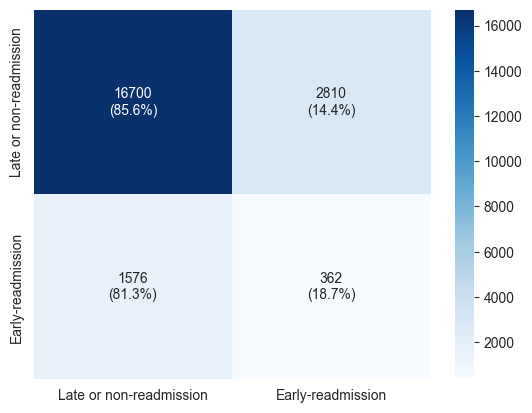

In [83]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

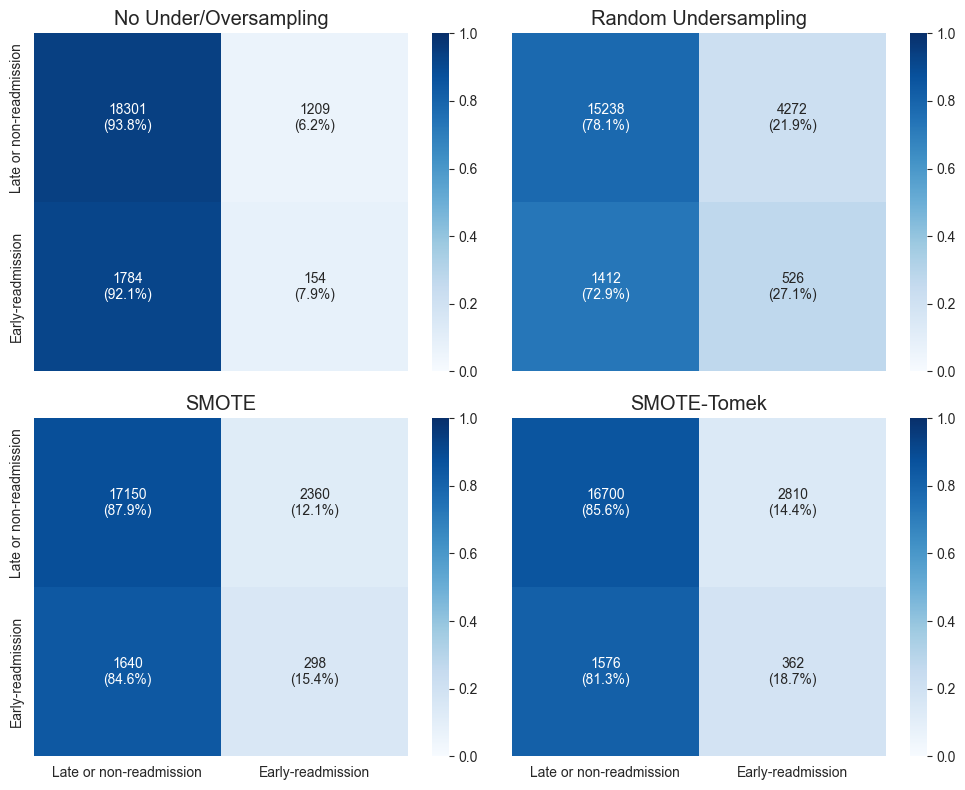

In [84]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [85]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.508748,0.512082,0.508857,0.508748,0.860453
Random Undersampling,0.526225,0.512412,0.499493,0.526225,0.734987
SMOTE,0.516402,0.512417,0.512620,0.516402,0.813502
SMOTE-Tomek,0.521381,0.513945,0.512804,0.521381,0.795505


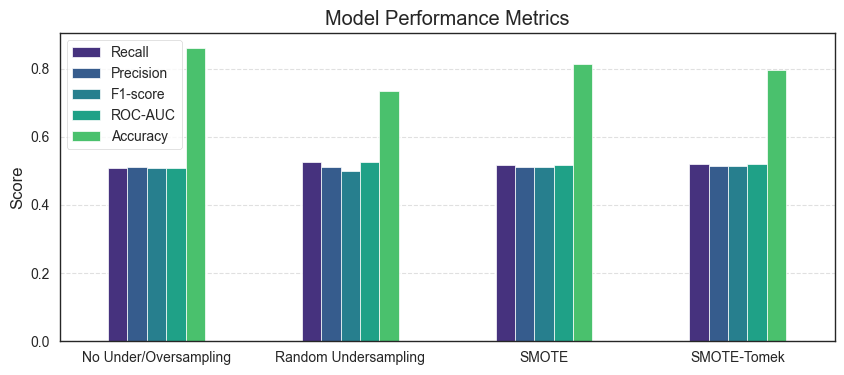

In [86]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()